In [1]:
import cython
import numpy as np
import TidalPy
import CyRK
print('TidalPy', TidalPy.__version__)
print('CyRK', CyRK.__version__)

TidalPy 0.5.0a5.dev14
CyRK 0.8.1


In [2]:
%load_ext cython

In [3]:
import matplotlib.pyplot as plt

def plot_ys(radius_array, ys):
    
    # Skip Complex
    all_ys = ys.shape[0]
    num_ys = int(all_ys/2)
    ys_plot = np.empty((num_ys, ys.shape[1]), dtype=np.float64)
    j = 0
    for i in range(all_ys):
        if i % 2:
            ys_plot[j, :] = ys[i, :]
            j+=1
    
    if num_ys == 2:
        ncols = 2
        nrows = 1        
    elif num_ys == 4:
        ncols = 2
        nrows = 2
    else:
        ncols = 3
        nrows = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    
    for i in range(nrows):
        for j in range(ncols):
            k = (i * ncols) + j
            axes[i, j].plot(radius_array/1000, ys[k, :])
    plt.show()

In [4]:
import numpy as np
from scipy.constants import G

from TidalPy.rheology.complex_compliance.compliance_models import newton, elastic, maxwell
from TidalPy.radial_solver.numerical.initial import find_initial_guess
from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays
from TidalPy.radial_solver.nondimensional import non_dimensionalize_physicals

radius = np.linspace(0.1, 6.371e6, 50)
bulk_density = 5515.0
density = np.ones_like(radius) * bulk_density
shear_modulus = 50e9 * np.ones_like(radius)
viscosity = 1.0e18 * np.ones_like(radius)
bulk_modulus = np.ones_like(radius) * 100.0e9
G_to_use = G
order_l = 2
frequency = 2 * np.pi / (24 * 60 * 60)
complex_shear = maxwell(frequency, shear_modulus**(-1), viscosity)**(-1)

volume_array, mass_array, gravity = calculate_mass_gravity_arrays(radius, density, G_to_use)

use_non_dim = True
if use_non_dim:
    radius_prime, gravity_prime, density_prime, shear_modulus_prime, bulk_modulus_prime, frequency_prime, newton_g_prime = \
    non_dimensionalize_physicals(radius, gravity, density, complex_shear, bulk_modulus, frequency, radius[-1], bulk_density)
else:
    radius_prime = radius
    gravity_prime = gravity
    density_prime = density
    shear_modulus_prime = complex_shear
    bulk_modulus_prime = bulk_modulus
    frequency_prime = frequency
    newton_g_prime = G

init_guess = find_initial_guess(
        is_solid=False, is_static=False, is_incompressible=False, is_kamata=False,
        radius=radius_prime[0], shear_modulus=shear_modulus_prime[0], bulk_modulus=bulk_modulus_prime[0],
        density=density_prime[0], frequency=frequency_prime, order_l=order_l, G_to_use=newton_g_prime
    )

print(frequency_prime)
t_span = (radius_prime[0], radius_prime[-1])

solutions = list()
for sol in init_guess:
    num_y = sol.size
    y0 = np.zeros(num_y*2, dtype=np.float64, order='C')
    for i in range(num_y):
        y0[2 * i] = np.real(sol[i])
        y0[2 * i + 1] = np.imag(sol[i])
    solutions.append(y0)

0.0676262910543706


In [5]:
from TidalPy.radial_solver.numerical.derivatives.odes import dynamic_liquid_ode

from scipy.integrate import solve_ivp
from CyRK import nbrk_ode, cyrk_ode

def dynamic_liquid_ode_cy(r, y, dy, *args):
    
    out = dynamic_liquid_ode(r, y, *args)
    
    for i in range(y.size):
        dy[i] = out[i]

High Res
True
Integration completed without issue.
(1979,)
(8, 1979)


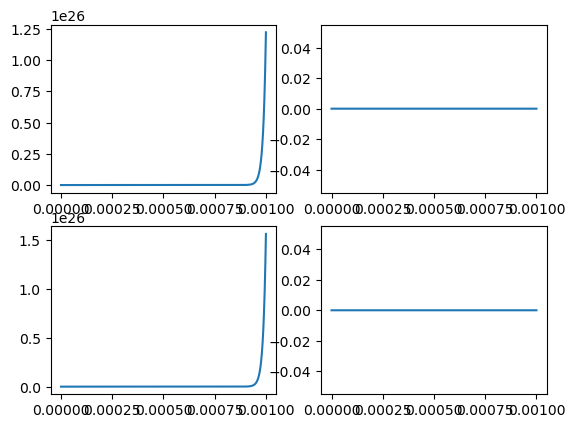

In [6]:
from TidalPy.radial_solver.numerical.derivatives.odes import dynamic_liquid_ode

from scipy.integrate import solve_ivp

rtol_const = 1.0e-9
atol_const = 1.0e-10
y0 = solutions[0]

out_cy_HighRes = cyrk_ode(
        dynamic_liquid_ode_cy,
        (radius_prime[0], radius_prime[-1]),
        y0,
        args=(radius_prime, bulk_modulus_prime, density_prime, gravity_prime, frequency_prime, order_l, newton_g_prime, False),
        rtol=rtol_const, atol=atol_const,
        rk_method=1)


print('High Res')
print(out_cy_HighRes[2])
print(out_cy_HighRes[3])
print(out_cy_HighRes[0].shape)
print(out_cy_HighRes[1].shape)

plot_ys(out_cy_HighRes[0], out_cy_HighRes[1])

CyODE_LowRes
23.2 ms ± 217 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
True
Integration completed without issue.
(686,)
(8, 686)


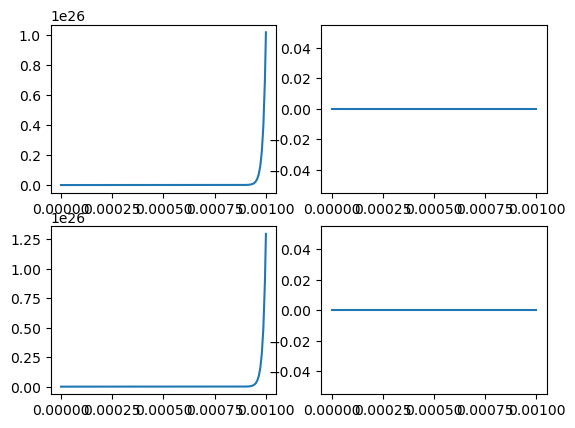



SciPy_LowRes
83.2 ms ± 236 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
True
(672,)
(8, 672)


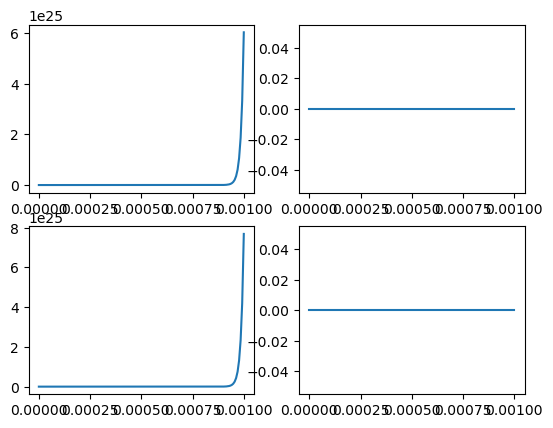

In [7]:
rtols = 1.0e-5 * np.ones(solutions[0].size, dtype=np.float64, order='C')
rtols[2] = 1.0e-6

print('CyODE_LowRes')
out_cyODE_LowRes = cyrk_ode(dynamic_liquid_ode_cy, t_span, y0, args=(radius_prime, bulk_modulus_prime, density_prime, gravity_prime, frequency_prime, order_l, newton_g_prime, False), rtol=rtol_const, atol=atol_const, rtols=rtols, rk_method=1)
%timeit cyrk_ode(dynamic_liquid_ode_cy, t_span, y0, args=(radius_prime, bulk_modulus_prime, density_prime, gravity_prime, frequency_prime, order_l, newton_g_prime, False), rtol=rtol_const, atol=atol_const, rtols=rtols, rk_method=1)
print(out_cyODE_LowRes[2])
print(out_cyODE_LowRes[3])
print(out_cyODE_LowRes[0].shape)
print(out_cyODE_LowRes[1].shape)
plot_ys(out_cyODE_LowRes[0], out_cyODE_LowRes[1])

print('\n\nSciPy_LowRes')
sol = solve_ivp(dynamic_liquid_ode, t_span, y0, method='RK45', rtol=rtols, atol=atol_const, args=(radius_prime, bulk_modulus_prime, density_prime, gravity_prime, frequency_prime, order_l, newton_g_prime, False))
%timeit solve_ivp(dynamic_liquid_ode, t_span, y0, method='RK45', rtol=rtols, atol=atol_const, args=(radius_prime, bulk_modulus_prime, density_prime, gravity_prime, frequency_prime, order_l, newton_g_prime, False))
print(sol.success)
print(sol.t.shape)
print(sol.y.shape)

plot_ys(sol.t, sol.y)

CySolver
607 µs ± 1.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
True
Integration completed without issue.
(686,)
(8, 686)


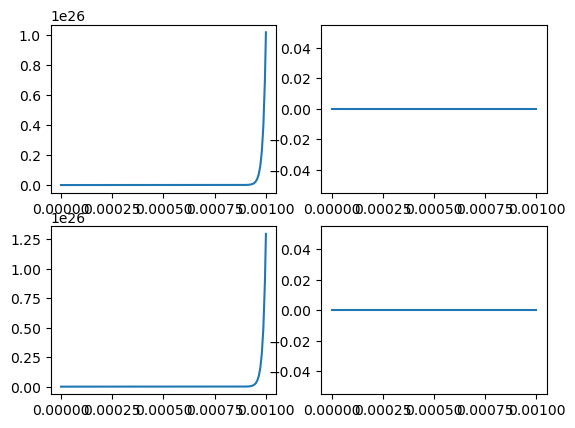

In [9]:
from TidalPy.radial_solver.numerical.derivatives.odes_x import LiquidDynamicCompressible

print('CySolver')
SolverInst = LiquidDynamicCompressible(radius_prime, density_prime, gravity_prime, shear_modulus_prime, bulk_modulus_prime, frequency_prime, order_l, newton_g_prime, t_span=t_span, y0=y0, rtol=rtol_const, atol=atol_const, rtols=rtols, atols=None, max_num_steps=1_000_000, expected_size=2000, rk_method=1, auto_solve=True, limit_solution_to_radius=False)
%timeit LiquidDynamicCompressible(radius_prime, density_prime, gravity_prime, shear_modulus_prime, bulk_modulus_prime, frequency_prime, order_l, newton_g_prime, t_span=t_span, y0=y0, rtol=rtol_const, atol=atol_const, rtols=rtols, atols=None, max_num_steps=1_000_000, expected_size=2000, rk_method=1, auto_solve=True, limit_solution_to_radius=False)
print(SolverInst.success)
print(SolverInst.message)
print(SolverInst.t.shape)
print(SolverInst.y.shape)

plot_ys(SolverInst.t, SolverInst.y)

In [ ]:
for i in range(out_cy_HighRes[1].shape[0]):
    print()
    print('y', i)
    print(out_cy_HighRes[1][i, -1])
    print('cyODE_lowRes', out_cyODE_LowRes[1][i, -1], 100 * np.abs(out_cy_HighRes[1][i, -1] - out_cyODE_LowRes[1][i, -1])/out_cy_HighRes[1][i, -1])
    print('SciPy_LowRes', sol.y[i, -1], 100 * np.abs(out_cy_HighRes[1][i, -1] - sol.y[1][i, -1])/out_cy_HighRes[1][i, -1])
    print('CySolver', SolverInst.y[i, -1], 100 * np.abs(out_cy_HighRes[1][i, -1] - SolverInst.y[i, -1])/out_cy_HighRes[1][i, -1])

## Radial Solver Function


In [ ]:
%%cython --annotate --force
# distutils: language = c++

from libcpp cimport bool as cpp_bool_t
import numpy as np
cimport numpy as np

from scipy.constants import G as G_
from TidalPy.radial_solver.nondimensional import non_dimensionalize_physicals, re_dimensionalize_radial_func
from TidalPy.radial_solver.numerical.collapse import collapse_solutions
from TidalPy.radial_solver.numerical.initial import find_initial_guess
from TidalPy.radial_solver.numerical.interfaces import find_interface_func

# Import cythonized functions
from TidalPy.radial_solver.numerical.interfaces.interfaces_x cimport find_solution_num


# Setup globals
cdef double G
G = G_


def radial_solver_x(double[:] radius_array,
                    double complex[:] complex_shear_array,
                    double[:] bulk_array,
                    double[:] density_array,
                    double[:] gravity_array,
                    double frequency,
                    double planet_bulk_density,
                    tuple is_solid_by_layer,
                    tuple is_static_by_layer,
                    tuple is_incompressible_by_layer,
                    tuple indices_by_layer,
                    unsigned int degree_l = 2, 
                    double complex[:] surface_boundary_conditions = None,
                    cpp_bool_t solve_load_numbers = False,
                    cpp_bool_t use_kamata = False,
                    int integration_method = 1,
                    double integration_rtol = 1.0e-8,
                    double integration_atol = 1.0e-9, 
                    cpp_bool_t verbose = False,
                    cpp_bool_t nondimensionalize = True,
                    ):
    # General indexing
    cdef Py_ssize_t i, j, filled_j
    
    # Pull out key information
    cdef double radius_planet
    cdef Py_ssize_t num_layers, num_interfaces, num_radius
    radius_planet  = radius_array[-1]
    # TODO: Exception to check if there is at least one layer?
    num_layers     = len(is_solid_by_layer)
    num_interfaces = num_layers - 1
    num_radius     = len(radius_array)
    
    # Non-dimensionalize inputs
    cdef double G_to_use
    
    if nondimensionalize:
        radius_array, gravity_array, density_array, complex_shear_array, bulk_array, frequency, G_to_use = \
            non_dimensionalize_physicals(
                    radius_array, gravity_array, density_array, complex_shear_array, bulk_array, frequency,
                    mean_radius=radius_planet, bulk_density=planet_bulk_density
                    )
    else:
        G_to_use = G
    
    # Find boundary condition at the top of the planet -- this is dependent on the forcing type.
    #     Tides (default here) follow the (y2, y4, y6) = (0, 0, (2l+1)/R) rule
    cdef np.ndarray[np.complex128_t, ndim=1] bc_array
    cdef double complex[:] bc_array_view
    bc_array = np.empty(3, dtype=np.complex128)
    bc_array_view = bc_array
    
    if surface_boundary_conditions is None:
        # Assume tides
        for i in range(3):
            if i == 2:
                if nondimensionalize:
                    bc_array_view[i] == (2. * degree_l + 1.) / 1.
                else:
                    bc_array_view[i] == (2. * degree_l + 1.) / radius_planet
    else:
        # Use user input
        # TODO: Exception if user input is wrong size.
        for i in range(3):
            bc_array_view[i] = surface_boundary_conditions[i]
    
    # Find number of solutions per layer
    cdef np.ndarray[np.uint16_t, ndim=1] num_solutions_by_layer_array
    cdef unsigned short num_solutions_by_layer_view
    num_solutions_by_layer_array = np.zeros(num_layers, dtype=np.ushort)
    num_solutions_by_layer_view = num_solutions_by_layer_array
    
    cdef np.ndarray[np.uint8_t, ndim=2] indices_by_layer_array
    cdef unsigned char[:, :] indices_by_layer_view
    indices_by_layer_array = np.zeros((num_layers, num_radius), dtype=np.uint8)
    indices_by_layer_view = indices_by_layer_array
    
    cdef Py_ssize_t num_radius_in_layer
    cdef np.ndarray[np.uint32_t, ndim=1] layer_length_array
    cdef unsigned int[:] layer_length_view
    layer_length_array = np.zeros(num_layers, dtype=np.uint32)
    layer_length_view = layer_length_array
    
    cdef cpp_bool_t layer_is_solid, layer_is_static, layer_is_incomp
    
    for i in range(num_layers):
        
        layer_is_solid = is_solid_by_layer[i]
        layer_is_static = is_static_by_layer[i]
        layer_is_incomp = is_incompressible_by_layer[i]
        
        num_solutions_by_layer_array[i] = find_solution_num(layer_is_solid, layer_is_static, layer_is_incomp)
        
        # Determine which radii fall within this layer
        num_radius_in_layer = 0
        for j in range(num_radius):
            if indices_by_layer[i][j] == 1:
                indices_by_layer_view[i, j] = 1
                num_radius_in_layer += 1
        layer_length_view[i] = <unsigned int>num_radius_in_layer
                
        
    
    # Store solutions per layer.
    # TODO: Make this a ndarray?
    cdef list solutions_by_layer_list
    solutions_by_layer_list = list()
    
    # Other variables
    cdef np.ndarray[np.float64_t, ndim=1] layer_radii_array, layer_bulk_array, layer_density_array, layer_gravity_array
    cdef np.ndarray[np.complex128_t, ndim=1] layer_shear_array
    cdef double[:] layer_radii_view, layer_bulk_view, layer_density_view, layer_gravity_view
    cdef double complex[:] layer_shear_view
    
    cdef np.ndarray[np.complex128_t, ndim=2] solutions_below_array
    cdef double complex[:, :] solutions_below_view
    
    cdef double layer_radius_lower, layer_radius_upper
    cdef double layer_gravity_lower, layer_gravity_upper
    cdef double layer_density_lower, layer_bulk_lower
    cdef double complex layer_shear_lower
    
    cdef Py_ssize_t n_layer_radius
    cdef unsigned short layer_num_solutions
    
    # # Main Solution Loop
    # Ready to solve the viscoelastic-gravitational problem for each layer, obtaining multiple solutions per layer
    #  which will later be collapsed via a linear combination (subjected to boundary conditions) into a single
    #  solution for the entire planet.
    
    # Loop through layers from bottom to top and solve the differential equations
    for i in range(num_layers):
        
        # Pull out layer information
        num_radius_in_layer = <Py_ssize_t>layer_length_view[i]
        # Build arrays filled with this layer's properties
        layer_radii_array   = np.empty(num_radius_in_layer, dtype=np.float64)
        layer_bulk_array    = np.empty(num_radius_in_layer, dtype=np.float64)
        layer_density_array = np.empty(num_radius_in_layer, dtype=np.float64)
        layer_gravity_array = np.empty(num_radius_in_layer, dtype=np.float64)
        layer_shear_array   = np.empty(num_radius_in_layer, dtype=np.complex128)
        layer_radii_view    = layer_radii_array
        layer_bulk_view     = layer_bulk_array
        layer_density_view  = layer_density_array
        layer_gravity_view  = layer_gravity_array
        layer_shear_view    = layer_shear_array
        filled_j = 0
        for j in range(num_radius):
            if indices_by_layer_view[i, j] == 1:
                layer_radii_view[filled_j]   = radius_array[j]
                layer_bulk_view[filled_j]    = bulk_array[j]
                layer_density_view[filled_j] = density_array[j]
                layer_gravity_view[filled_j] = gravity_array[j]
                layer_shear_view[filled_j]   = complex_shear_array[j]
                filled_j += 1
        
        # Get properties at the base of the layer
        layer_shear_lower   = layer_shear_view[0]
        layer_bulk_lower    = layer_bulk_view[0]
        layer_density_lower = layer_density_view[0]
        layer_gravity_lower = layer_gravity_view[0]
        layer_radius_lower  = layer_radii_view[0]
        
        # Get properties at the top of the layer
        layer_radius_upper  = layer_radii_view[num_radius_in_layer - 1]
        layer_gravity_upper = layer_gravity_view[num_radius_in_layer - 1]
        
        # Get physical state of layer
        layer_is_solid      = is_solid_by_layer[i]
        layer_is_static     = is_static_by_layer[i]
        layer_is_incomp     = is_incompressible_by_layer[i]
        
        # Get integration information for layer
        layer_num_solutions = num_solutions_by_layer_array[i]
        
        # Find initial conditions at bottom of layer
        if i == 0:
            # Use initial condition function
            find_initial_guess(
                        layer_is_solid, layer_is_static, layer_is_incomp, use_kamata,
                        layer_radius_lower, layer_shear_lower, layer_bulk_lower, layer_density_lower, frequency,
                        order_l=degree_l, G_to_use=G_to_use
                        )
        else:
            # Use results at the top of the layer below and a interface function
            pass
            
            
            
    
            
            
        
    